<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/team02/Main/get_data_Arush.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 

In [3]:
loadfile = np.load("/content/drive/MyDrive/IITR EEG Intern/New Problem/meditation_data.npz")
data = loadfile["X"]
y = loadfile["y"]

In [4]:
y = tf.keras.utils.to_categorical(y, 4)

In [5]:
print(data.shape)
print(y.shape)

(24756, 32, 513)
(24756, 4)


In [6]:
X = np.zeros((data.shape[0], data.shape[2], data.shape[1]))
for i in range(data.shape[0]):
    X[i] = np.transpose(data[i])

In [7]:
del data
del loadfile

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train,x_temp,y_train,y_temp = train_test_split(X,y,test_size=0.30,shuffle=True,stratify=y,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.50,shuffle=True,stratify=y_temp,random_state=42)

In [10]:
x_train[0].shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((513, 32), (17329, 4), (3713, 513, 32), (3713, 4), (3714, 513, 32), (3714, 4))

In [11]:
dims_conv_1 = X.shape[1]
dims_conv_2 = X.shape[2]

In [12]:
print(dims_conv_1)
print(dims_conv_2)

513
32


### 1. 1D Convolution Model

In [13]:
inp_shape = (dims_conv_1, dims_conv_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3,)(ip)
rel = tf.keras.layers.LeakyReLU()(conv1)
conv2 = tf.keras.layers.Conv1D(16, 3,)(rel)
rel2 = tf.keras.layers.LeakyReLU()(conv2)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(rel2)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.3)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.3)(dense2)
out = tf.keras.layers.Dense(4, activation = 'softmax')(drop2)

cnn = tf.keras.Model(inputs = ip, outputs = out)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 513, 32)]         0         
                                                                 
 conv1d (Conv1D)             (None, 511, 32)           3104      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 511, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 16)           1552      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 509, 16)           0         
                                                                 
 flatten (Flatten)           (None, 8144)              0         
                                                                 
 dense (Dense)               (None, 32)                260640

In [14]:
# Compiling the model

cnn_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'cnn_checkpoint/checkpoint_{epoch:02d}';
cnn_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

cnn.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [ ]:
cnn_history = cnn.fit(x_train, y_train,
                        validation_data = (x_test, y_test),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 30,
                        callbacks = [cnn_checkpoint]) #Fitting the model

Epoch 1/30
542/542 [==============================] - ETA: 0s - loss: 1.8144 - acc: 0.2545
Epoch 00001: val_acc improved from -inf to 0.28783, saving model to cnn_checkpoint/checkpoint_01
542/542 [==============================] - 18s 15ms/step - loss: 1.8144 - acc: 0.2545 - val_loss: 1.3663 - val_acc: 0.2878
Epoch 2/30
542/542 [==============================] - ETA: 0s - loss: 1.3927 - acc: 0.2869
Epoch 00002: val_acc improved from 0.28783 to 0.31206, saving model to cnn_checkpoint/checkpoint_02
542/542 [==============================] - 4s 8ms/step - loss: 1.3927 - acc: 0.2869 - val_loss: 1.3529 - val_acc: 0.3121
Epoch 3/30
535/542 [============================>.] - ETA: 0s - loss: 1.3430 - acc: 0.3195
Epoch 00003: val_acc improved from 0.31206 to 0.32903, saving model to cnn_checkpoint/checkpoint_03
542/542 [==============================] - 4s 8ms/step - loss: 1.3438 - acc: 0.3196 - val_loss: 1.3131 - val_acc: 0.3290
Epoch 4/30
542/542 [==============================] - ETA: 0s - l

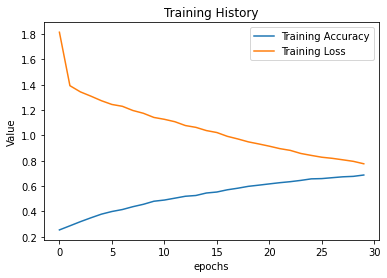

Initial training accuracy with preprocessing is:  0.2545444071292877
Final training accuracy with preprocessing is:  0.6878065466880798
Initial training loss with preprocessing is:  1.8144330978393555
Final training loss with preprocessing is:  0.7764544486999512


In [ ]:
#Plotting model history
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", cnn_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", cnn_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", cnn_history.history['loss'][0])
print("Final training loss with preprocessing is: ", cnn_history.history['loss'][-1])

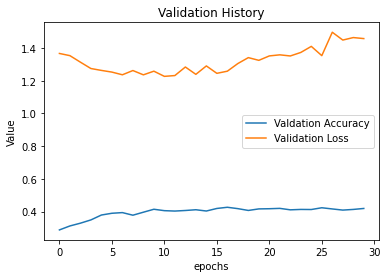

Initial Validation accuracy with preprocessing is:  0.28782984614372253
Final Validation accuracy with preprocessing is:  0.4189552962779999
Initial Validation loss with preprocessing is:  1.366343379020691
Final Validation loss with preprocessing is:  1.4572583436965942


In [ ]:
#Plotting model history
plt.plot(cnn_history.history['val_acc'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", cnn_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", cnn_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", cnn_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", cnn_history.history['val_loss'][-1])

### 2. Feature Extraction Model

In [15]:
inp_shape = (dims_conv_1, dims_conv_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(ip)
conv1 = tf.keras.layers.ZeroPadding1D(padding=1)(conv1)
rel1 = tf.keras.layers.ReLU()(conv1)
skip1 = rel1
conv2 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(rel1)
conv2 = tf.keras.layers.ZeroPadding1D(padding=1)(conv2)
rel2 = tf.keras.layers.ReLU()(conv2)
skip2 = rel2
conv3 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(rel2)
conv3 = tf.keras.layers.ZeroPadding1D(padding=1)(conv3)
rel3 = tf.keras.layers.ReLU()(conv3)
addlayer1 = tf.keras.layers.Add()([skip1, skip2, rel3])
flatten = tf.keras.layers.Flatten()(addlayer1)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(dense1)
drop2 = tf.keras.layers.Dropout(.3)(dense2)
out = tf.keras.layers.Dense(4, activation = 'softmax')(drop2)

ftExtract = tf.keras.Model(inputs = ip, outputs = out)
ftExtract.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 513, 32)]    0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 511, 16)      1552        ['input_2[0][0]']                
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 513, 16)     0           ['conv1d_2[0][0]']               
                                                                                                  
 re_lu (ReLU)                   (None, 513, 16)      0           ['zero_padding1d[0][0]']         
                                                                                            

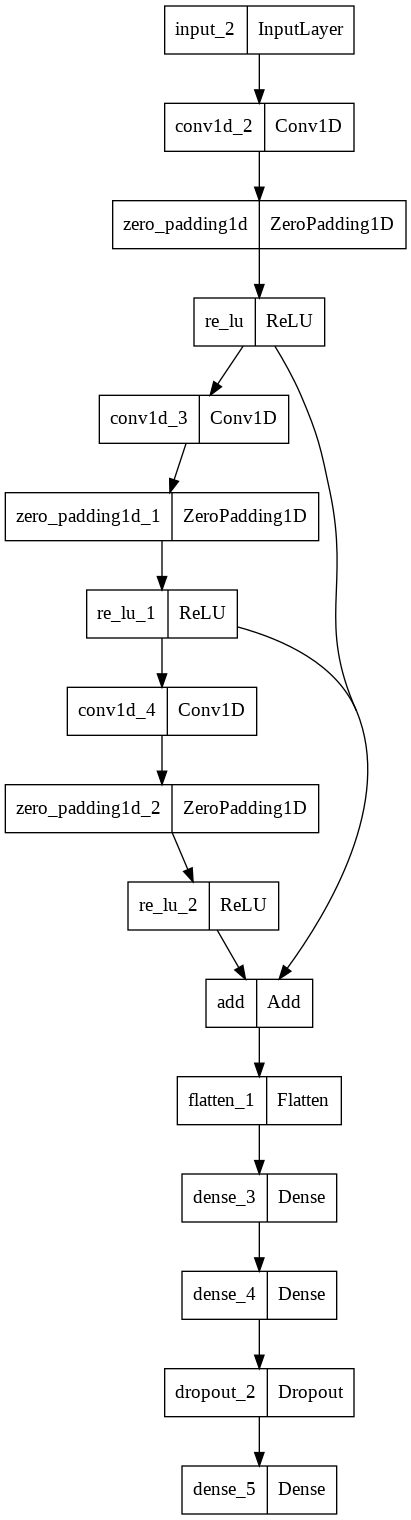

In [16]:
tf.keras.utils.plot_model(ftExtract)

In [17]:
# Compiling the model
fte_earlystop = EarlyStopping(patience = 15, min_delta = 0.001, monitor = 'val_acc')

path = 'fte_checkpoint/checkpoint_{epoch:02d}';
fte_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

ftExtract.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [18]:
ftExtract_history = ftExtract.fit(x_train, y_train,
                      validation_data = (x_temp, y_temp),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [fte_checkpoint],
                    ) #Fitting the model

Epoch 1/50
542/542 [==============================] - ETA: 0s - loss: 3.5174 - acc: 0.2514
Epoch 00001: val_acc improved from -inf to 0.27131, saving model to fte_checkpoint/checkpoint_01
542/542 [==============================] - 17s 14ms/step - loss: 3.5174 - acc: 0.2514 - val_loss: 1.3892 - val_acc: 0.2713
Epoch 2/50
538/542 [============================>.] - ETA: 0s - loss: 1.5025 - acc: 0.2728
Epoch 00002: val_acc improved from 0.27131 to 0.28989, saving model to fte_checkpoint/checkpoint_02
542/542 [==============================] - 6s 11ms/step - loss: 1.5023 - acc: 0.2730 - val_loss: 1.3643 - val_acc: 0.2899
Epoch 3/50
537/542 [============================>.] - ETA: 0s - loss: 1.3802 - acc: 0.3106
Epoch 00003: val_acc improved from 0.28989 to 0.32961, saving model to fte_checkpoint/checkpoint_03
542/542 [==============================] - 6s 11ms/step - loss: 1.3802 - acc: 0.3108 - val_loss: 1.3226 - val_acc: 0.3296
Epoch 4/50
541/542 [============================>.] - ETA: 0s -

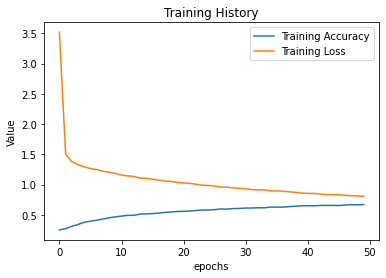

Initial training accuracy with preprocessing is:  0.2514282464981079
Final training accuracy with preprocessing is:  0.6703214049339294
Initial training loss with preprocessing is:  3.5173797607421875
Final training loss with preprocessing is:  0.8064739108085632


In [19]:
#Plotting model history
plt.plot(ftExtract_history.history['acc'])
plt.plot(ftExtract_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", ftExtract_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", ftExtract_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", ftExtract_history.history['loss'][0])
print("Final training loss with preprocessing is: ", ftExtract_history.history['loss'][-1])

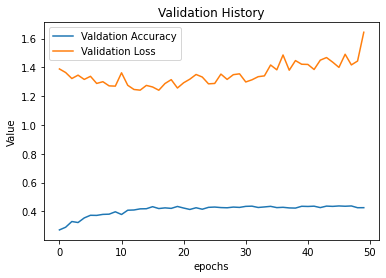

Initial Validation accuracy with preprocessing is:  0.2713073790073395
Final Validation accuracy with preprocessing is:  0.4257439076900482
Initial Validation loss with preprocessing is:  1.3892027139663696
Final Validation loss with preprocessing is:  1.6440006494522095


In [20]:
#Plotting model history
plt.plot(ftExtract_history.history['val_acc'])
plt.plot(ftExtract_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][-1])